# <span style="color:blue">0 Initialization</span>

In [1]:
import csv, sys, math, copy
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

In [2]:
class DatasetType(Enum):
    imdb_1m = 'imdb-1m'
    imdb_25m = 'imdb-25m'

In [3]:
dataset_type = DatasetType.imdb_1m.value

In [4]:
dataset_base_path = f'../../preparation/imdb/{dataset_type}'
dataset_movies_path = f'{dataset_base_path}/movies.csv'
dataset_interactions_path = f'{dataset_base_path}/interactions.csv'
dataset_interaction_counts_path = f'{dataset_base_path}/interaction-counts.csv'
dataset_selected_features_path = f'{dataset_type}/selected-features.csv'
matrices_base_path = f'{dataset_type}/matrices'

In [5]:
if dataset_type == DatasetType.imdb_25m:
    csv.field_size_limit(sys.maxsize)

In [6]:
def get_boundary(values: list):
    percentile = 0.999 if dataset_type == DatasetType.imdb_25m else 0.99
    index = round(percentile * len(values)) - 1
    return values[index]


def scale_type1(value, boundary):
    return round(math.tan((math.pi * value) / (3 * boundary)) / math.tan(math.pi / 3), 5)


def scale_type2(value, boundary):
    return round(math.tanh(value / boundary), 5)

# <span style="color:blue">1 item features</span>

## <span style="color:green">1.1 get movies.csv data</span>

In [7]:
with open(dataset_movies_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    headers = next(csv_reader)
    movies = [row for row in csv_reader]

print(headers)

['imdbId', 'type', 'name', 'ratingCount', 'bestRating', 'worstRating', 'ratingValue', 'contentRating', 'genre', 'datePublished', 'keywords', 'actor', 'director', 'creator', 'duration', 'popularity', 'userReviews', 'criticReviews', 'metaScore']


## <span style="color:green">1.2 selected features</span>
#### - imdbId
#### - type
#### - ratingCount
#### - ratingValue
#### - genre
#### - userReviews
#### - criticReviews

In [8]:
imdbId_index = headers.index('imdbId')
type_index = headers.index('type')
ratingCount_index = headers.index('ratingCount')
ratingValue_index = headers.index('ratingValue')
genre_index = headers.index('genre')
userReviews_index = headers.index('userReviews')
criticReviews_index = headers.index('criticReviews')

In [9]:
movie_types, genres = [], []

for movie in movies:
    # movie types
    if (movie_type := movie[type_index]) and (movie_type not in movie_types):
        movie_types.append(movie_type)

    # genres
    if genre := movie[genre_index]:
        for genre in genre.split(','):
            (genre not in genres) and genres.append(genre)

print(f'movie types:\n{movie_types}\n')
print(f'genres:\n{genres}\n')

movie types:
['Movie', 'TVSeries', 'TVEpisode']

genres:
['Short', 'Comedy', 'Drama', 'Adventure', 'Western', 'Romance', 'Family', 'Fantasy', 'Horror', 'History', 'Thriller', 'Sport', 'Crime', 'Mystery', 'Sci-Fi', 'Action', 'War', 'Animation', 'Musical', 'Documentary', 'Music', 'Biography', 'Film-Noir', 'News']


## <span style="color:green">1.3 clean features</span>

In [10]:
def get_type_vector(_type):
    type_vector = [0] * len(movie_types)

    if _type in movie_types:
        type_vector[movie_types.index(_type)] = 1

    return type_vector


def get_genre_vector(_genres):
    genre_vector = [0] * len(genres)

    if _genres is None:
        return genre_vector

    for _genre in _genres.split(','):
        if _genre in genres:
            genre_vector[genres.index(_genre)] = 1

    return genre_vector

In [11]:
new_headers = ['imdbId']
new_headers.extend(list(map(lambda key: f'type{key}', movie_types)))
new_headers.extend(['ratingCount', 'ratingValue'])
new_headers.extend(list(map(lambda key: f'genre{key}', genres)))
new_headers.extend(['userReviews', 'criticReviews'])

In [12]:
new_imdbId_index = new_headers.index('imdbId')
new_ratingCount_index = new_headers.index('ratingCount')
new_ratingValue_index = new_headers.index('ratingValue')
new_userReviews_index = new_headers.index('userReviews')
new_criticReviews_index = new_headers.index('criticReviews')

In [13]:
new_rows = [new_headers]

for movie in movies:
    imdbId = movie[imdbId_index]

    type_vector = get_type_vector(movie[type_index])

    ratingCount = movie[ratingCount_index]
    if ratingCount == '': ratingCount = 0

    ratingValue = movie[ratingValue_index]
    if ratingValue == '': ratingValue = 0

    genre_vector = get_genre_vector(movie[genre_index])

    userReviews = movie[userReviews_index]
    if userReviews == '':
        userReviews = 0
    elif 'k' in userReviews.lower():
        userReviews = float(userReviews[:-1]) * 1000

    criticReviews = movie[criticReviews_index]
    if criticReviews == '':
        criticReviews = 0
    elif 'k' in criticReviews.lower():
        criticReviews = float(criticReviews[:-1]) * 1000

    new_row = [imdbId]
    new_row.extend(type_vector)
    new_row.append(int(ratingCount))
    new_row.append(float(ratingValue))
    new_row.extend(genre_vector)
    new_row.append(int(userReviews))
    new_row.append(int(criticReviews))

    new_rows.append(new_row)

In [14]:
ratingCount_boundary = get_boundary(sorted([new_row[new_ratingCount_index] for new_row in new_rows[1:]]))
userReviews_boundary = get_boundary(sorted([new_row[new_userReviews_index] for new_row in new_rows[1:]]))
criticReviews_boundary = get_boundary(sorted([new_row[new_criticReviews_index] for new_row in new_rows[1:]]))

new_rows_unscaled = copy.deepcopy(new_rows)

for new_row in new_rows[1:]:
    new_row[new_ratingValue_index] = scale_type1(new_row[new_ratingValue_index], 10)  # ratingValue
    new_row[new_ratingCount_index] = scale_type2(new_row[new_ratingCount_index], ratingCount_boundary)  # ratingCount
    new_row[new_userReviews_index] = scale_type2(new_row[new_userReviews_index], userReviews_boundary)  # userReviews
    new_row[new_criticReviews_index] = scale_type2(new_row[new_criticReviews_index], criticReviews_boundary)  # criticReviews

In [15]:
with open(dataset_selected_features_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(new_rows)

## <span style="color:green">1.4 visualize scaled features</span>

In [16]:
ratingCount_scaling, ratingValue_scaling, userReviews_scaling, criticReviews_scaling = [], [], [], []

for new_row_unscaled, new_row in zip(new_rows_unscaled[1:], new_rows[1:]):
    ratingCount_scaling.append([new_row_unscaled[new_ratingCount_index], new_row[new_ratingCount_index]])
    ratingValue_scaling.append([new_row_unscaled[new_ratingValue_index], new_row[new_ratingValue_index]])
    userReviews_scaling.append([new_row_unscaled[new_userReviews_index], new_row[new_userReviews_index]])
    criticReviews_scaling.append([new_row_unscaled[new_criticReviews_index], new_row[new_criticReviews_index]])

ratingCount_scaling.sort(key=lambda x: x[0])
ratingValue_scaling.sort(key=lambda x: x[0])
userReviews_scaling.sort(key=lambda x: x[0])
criticReviews_scaling.sort(key=lambda x: x[0])

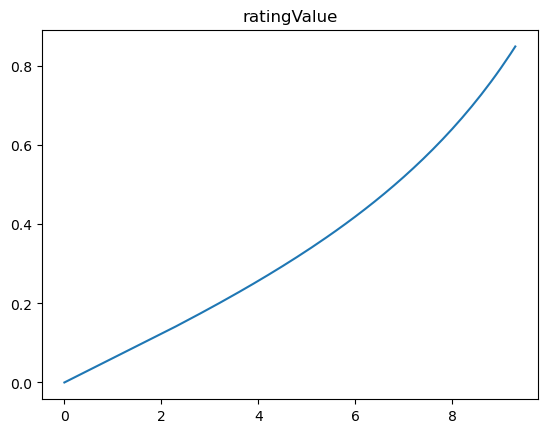

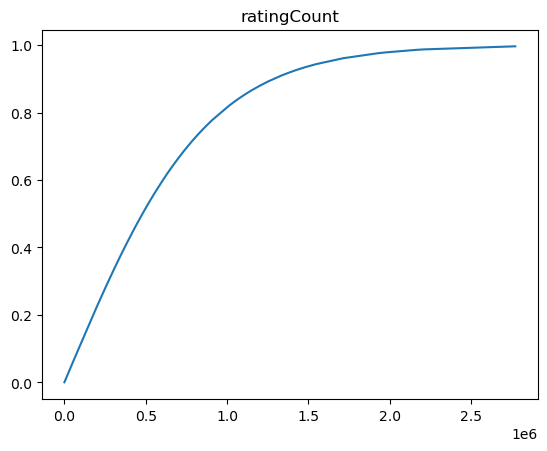

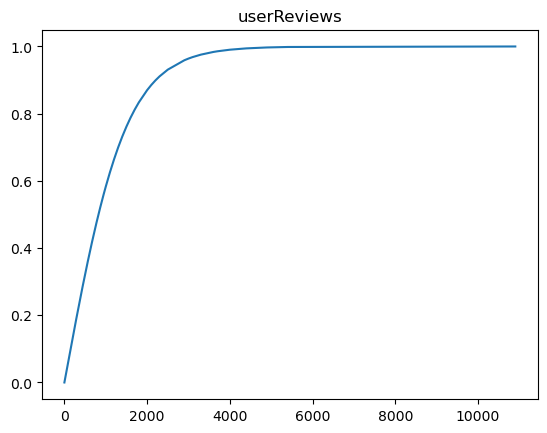

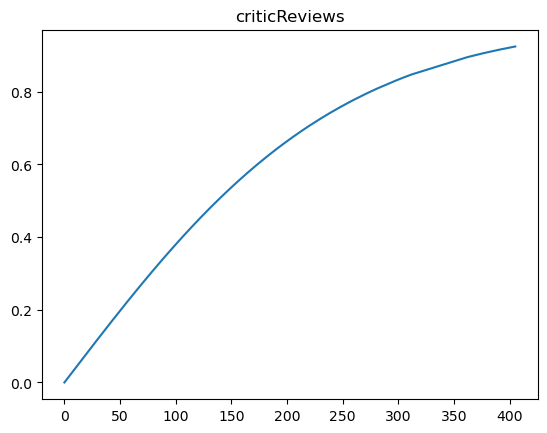

In [17]:
# ratingValue
X = np.array([point[0] for point in ratingValue_scaling])
Y = np.array([point[1] for point in ratingValue_scaling])
plt.title('ratingValue')
plt.plot(X, Y)
plt.show()

# ratingCount
X = np.array([point[0] for point in ratingCount_scaling])
Y = np.array([point[1] for point in ratingCount_scaling])
plt.title('ratingCount')
plt.plot(X, Y)
plt.show()

# userReviews
X = np.array([point[0] for point in userReviews_scaling])
Y = np.array([point[1] for point in userReviews_scaling])
plt.title('userReviews')
plt.plot(X, Y)
plt.show()

# criticReviews
X = np.array([point[0] for point in criticReviews_scaling])
Y = np.array([point[1] for point in criticReviews_scaling])
plt.title('criticReviews')
plt.plot(X, Y)
plt.show()

## <span style="color:green">1.5 required variables for matrix creation</span>
#### - num_items
#### - num_item_features
#### - new_rows

In [18]:
num_items = len(new_rows) - 1 # omit header names
num_item_features = len(new_rows[0]) - 1 # omit imdbId

# <span style="color:blue">2 item-item & user-item interactions</span>

## <span style="color:green">2.1 count item interactions</span>

In [19]:
with open(dataset_interactions_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    ui_interactions = [row for row in csv_reader]  # user-item interactions

In [20]:
with open(dataset_interaction_counts_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    ui_interaction_counts = [[row[0], int(row[1])] for row in csv_reader]  # user-item interaction counts

interaction_counts_unscaled = copy.deepcopy(ui_interaction_counts)

interaction_counts_boundary = get_boundary(sorted([int(row[1]) for row in ui_interaction_counts]))
for interaction_count in ui_interaction_counts:
    interaction_count[1] = scale_type2(int(interaction_count[1]), interaction_counts_boundary)

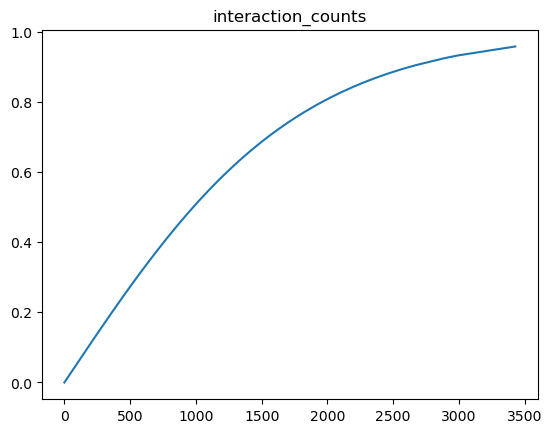

In [21]:
interaction_counts_scaling = []

for interaction_count_unscaled, interaction_count in zip(interaction_counts_unscaled, ui_interaction_counts):
    interaction_counts_scaling.append([interaction_count_unscaled[1], interaction_count[1]])

interaction_counts_scaling.sort(key=lambda x: x[0])

# interaction_counts
X = np.array([point[0] for point in interaction_counts_scaling])
Y = np.array([point[1] for point in interaction_counts_scaling])
plt.title('interaction_counts')
plt.plot(X, Y)
plt.show()

## <span style="color:green">2.2 required variables for matrix creation</span>
#### - ui_interactions
#### - ui_interaction_counts
#### - num_users

In [22]:
num_users = len(ui_interactions)

# <span style="color:blue">3 create matrices</span>

once below codes executed, the results will be available in 'matrices' directory
keep in mind that the order of data in these matrices is important

## <span style="color:green">3.1 item names</span>

In [23]:
item_names = [[f"item_{row[0]}"] for row in new_rows[1:]]
with open(f'{matrices_base_path}/item_names.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(item_names)

## <span style="color:green">3.2 item interactions</span>

In [24]:
item_interactions = np.memmap(
    f'{matrices_base_path}/item_interactions.dat',
    dtype=np.float32, mode='w+', shape=(num_items, 1)
)

for i in range(num_items):
    item_interactions[i] = ui_interaction_counts[i][1]

## <span style="color:green">3.3 item interactions diff</span>

In [25]:
item_interactions_diff = np.memmap(
    f'{matrices_base_path}/item_interactions_diff.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_items)
)

for i in range(num_items):
    diff = abs(item_interactions - item_interactions[i])
    item_interactions_diff[i, :] = np.reshape(diff, (diff.shape[0],))

## <span style="color:green">3.4 item features</span>

In [26]:
item_features = np.memmap(
    f'{matrices_base_path}/item_features.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_item_features)
)

for i in range(num_items):
    item_features[i, :] = new_rows[i + 1][1:]

## <span style="color:green">3.5 item-item weights</span>

In [27]:
ii_weights = np.memmap(
    f'{matrices_base_path}/ii_weights.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_items)
)

coefficient = 10 if dataset_type == DatasetType.imdb_25m else 8
chunk = int(num_items / coefficient)
start_point, end_point = 0, chunk

while start_point < num_items:
    item_features_chuck = item_features[start_point: (start_point + chunk), :]
    item_features_chuck = np.reshape(item_features_chuck, (chunk, num_item_features))

    dot_product = item_features_chuck @ item_features.T

    norm_f1, norm_f2 = np.linalg.norm(item_features_chuck, axis=1), np.linalg.norm(item_features, axis=1)
    norm_f1, norm_f2 = np.reshape(norm_f1, (chunk, 1)), np.reshape(norm_f2, (num_items, 1))
    norm_multiplication = norm_f1 @ norm_f2.T

    cosine_similarity = np.divide(dot_product, norm_multiplication)

    diff = np.reshape(item_interactions_diff[start_point: (start_point + chunk), :], (chunk, num_items))

    ii_weights[start_point: (start_point + chunk), :] = np.multiply(cosine_similarity, diff)

    start_point, end_point = start_point + chunk, end_point + chunk

    del item_features_chuck, dot_product, norm_f1, norm_f2, norm_multiplication, cosine_similarity, diff

ii_weights = np.clip(ii_weights, 0.0, None) # Convert negative values to zero

## <span style="color:green">3.6 user names</span>

In [28]:
user_names = [[f"user_{row[0]}"] for row in ui_interactions]
with open(f'{matrices_base_path}/user_names.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(user_names)

## <span style="color:green">3.7 user features</span>

In [29]:
user_features = np.memmap(
    f'{matrices_base_path}/user_features.dat',
    dtype=np.float32, mode='w+', shape=(num_users, num_item_features)
)

for i in range(num_users):
    for j in range(num_item_features):
        user_features[i][j] = np.random.uniform(0, 1)

## <span style="color:green">3.8 user-item weights</span>

In [30]:
ui_weights_unscaled = np.zeros((num_items, num_users))

for user, interactions in ui_interactions:
    for interaction in interactions.split(','):
        item, weight = interaction.split('#')
        ui_weights_unscaled[item_names.index([f"item_{item}"])][user_names.index([f"user_{user}"])] = np.float32(weight)

In [31]:
ui_weights = np.memmap(
    f'{matrices_base_path}/ui_weights.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_users)
)

for i in range(num_items):
    for j in range(num_users):
        ui_weights[i][j] = scale_type1(ui_weights_unscaled[i][j], 5)

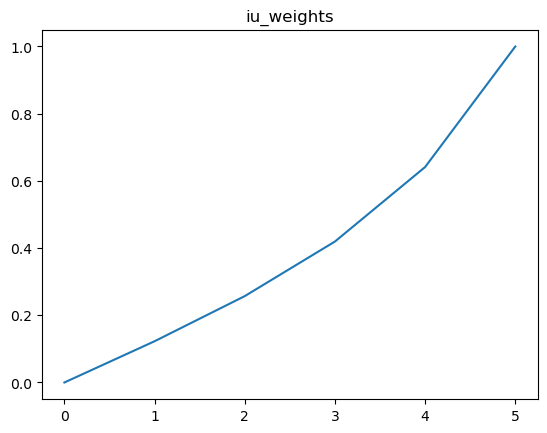

In [32]:
ui_weights_scaling = []

for ui_weight_unscaled, ui_weight in zip(ui_weights_unscaled, ui_weights):
    ui_weights_scaling.append([ui_weight_unscaled[1], ui_weight[1]])

ui_weights_scaling.sort(key=lambda x: x[0])

X = np.array([point[0] for point in ui_weights_scaling])
Y = np.array([point[1] for point in ui_weights_scaling])
plt.title('ui_weights')
plt.plot(X, Y)
plt.show()

# <span style="color:blue">4. plot histograms</span>

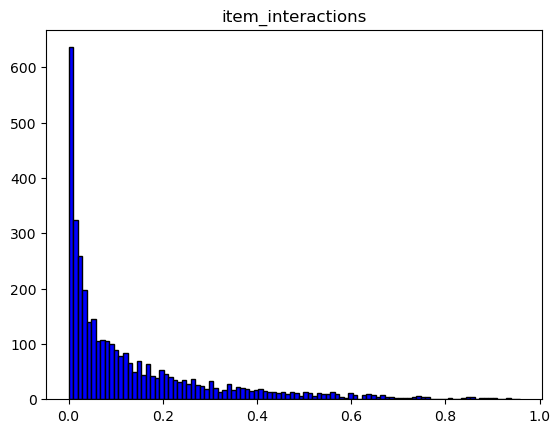

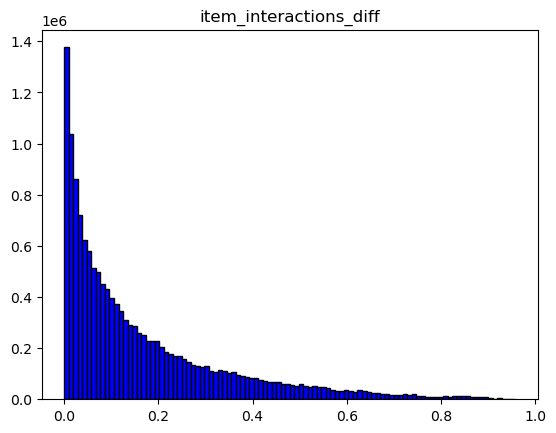

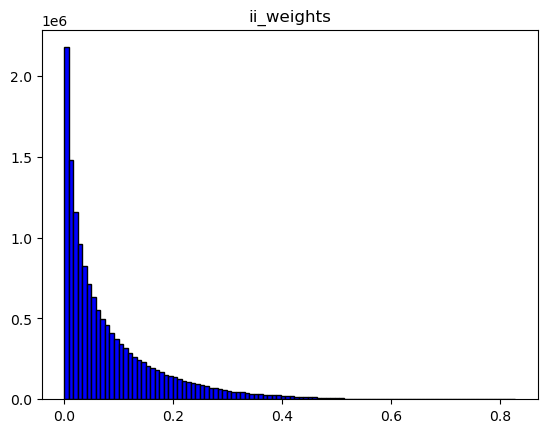

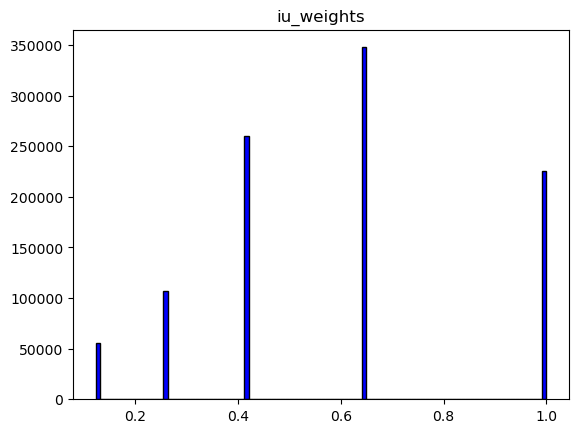

In [33]:
plt.hist(item_interactions[item_interactions != 0], bins=100, color='blue', edgecolor='black')
plt.title('item_interactions')
plt.show()

plt.hist(item_interactions_diff[item_interactions_diff != 0], bins=100, color='blue', edgecolor='black')
plt.title('item_interactions_diff')
plt.show()

plt.hist(ii_weights[ii_weights != 0], bins=100, color='blue', edgecolor='black')
plt.title('ii_weights')
plt.show()

plt.hist(ui_weights[ui_weights != 0], bins=100, color='blue', edgecolor='black')
plt.title('ui_weights')
plt.show()